# Reinforcement Learning - Deep Q Network
If you want to test/submit your solution **restart the kernel, run all cells and submit the dqn_autograde.py file into codegrade.**

In [1]:
from custommagics import CustomMagics
get_ipython().register_magics(CustomMagics)

In [27]:
%%execwritefile dqn_autograde.py
import numpy as np
import random
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm as _tqdm
import pandas as pd

def tqdm(*args, **kwargs):
    return _tqdm(*args, **kwargs, mininterval=1)  # Safety, do not overflow buffer

Overwriting dqn_autograde.py


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys
import time

assert sys.version_info[:3] >= (3, 6, 0), "Make sure you have Python 3.6 installed!"

## 1. Deep Q-Network (DQN)

In [4]:
import gym
env = gym.envs.make("Acrobot-v1")

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/opt/anaconda3/envs/rl2020/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [5]:
# env is a TimeLimit wrapper around an env, so use env.env to look into the env (but otherwise you can forget about this)
??env.env

In [6]:
# The nice thing about the CARTPOLE is that it has very nice rendering functionality (if you are on a local environment). Let's have a look at an episode
# obs = env.reset()
# env.render()
# done = False
# while not done:
#     obs, reward, done, _ = env.step(env.action_space.sample())
#     env.render()
#     time.sleep(0.05)
# env.close()  # Close the environment or you will have a lot of render screens soon

Remember from the previous lab, that in order to optimize a policy we need to estimate the Q-values (e.g. estimate the *action* values). In the CartPole problem, our state is current position of the cart, the current velocity of the cart, the current (angular) position of the pole and the (angular) speed of the pole. As these are continuous variables, we have an infinite number of states (ignoring the fact that a digital computer can only represent finitely many states in finite memory).

### 2.1 Implement Q-Network

We will not use the tabular approach but approximate the Q-value function by a general approximator function. We will skip the linear case and directly use a two layer Neural Network. We use [PyTorch](https://pytorch.org/) to implement the network, as this will allow us to train it easily later. We can implement a model using `torch.nn.Sequential`, but with PyTorch it is actually very easy to implement the model (e.g. the forward pass) from scratch. Now implement the `QNetwork.forward` function that uses one hidden layer with ReLU activation (no output activation).

In [7]:
%%execwritefile -a dqn_autograde.py

class QNetwork(nn.Module):
    
    def __init__(self, num_hidden=128):
        nn.Module.__init__(self)
        self.l1 = nn.Linear(6, num_hidden)
        self.l2 = nn.Linear(num_hidden, 3)

    def forward(self, x):
        # YOUR CODE HERE
        out = self.l1(x)
        out = F.relu(out)
        out = self.l2(out)
        
        return out

Appending to dqn_autograde.py


In [8]:
# Let's instantiate and test if it works
num_hidden = 128
torch.manual_seed(1)
Q_net = QNetwork(num_hidden)

torch.manual_seed(1)
test_model = nn.Sequential(
    nn.Linear(6, num_hidden), 
    nn.ReLU(), 
    nn.Linear(num_hidden, 3)
)

x = torch.rand(10, 6)
print(x)

# If you do not need backpropagation, wrap the computation in the torch.no_grad() context
# This saves time and memory, and PyTorch complaints when converting to numpy
with torch.no_grad():
    assert np.allclose(Q_net(x).numpy(), test_model(x).numpy())

tensor([[0.4707, 0.7595, 0.5687, 0.8585, 0.6079, 0.4938],
        [0.5709, 0.8333, 0.5755, 0.8522, 0.4526, 0.5043],
        [0.9201, 0.0280, 0.5499, 0.9567, 0.2491, 0.4078],
        [0.4699, 0.6647, 0.6890, 0.6133, 0.6972, 0.2855],
        [0.7104, 0.3415, 0.8142, 0.3533, 0.0742, 0.5357],
        [0.7602, 0.4804, 0.5065, 0.5018, 0.7654, 0.5391],
        [0.0533, 0.1434, 0.5296, 0.4599, 0.9779, 0.3825],
        [0.8827, 0.0783, 0.0248, 0.4540, 0.1834, 0.3542],
        [0.5563, 0.0663, 0.8436, 0.1966, 0.8836, 0.6634],
        [0.4062, 0.0624, 0.5828, 0.2207, 0.9321, 0.0794]])


### 2.2 Experience Replay

In order to stabilize learning, we will use an experience replay to save states in and sample states from. Now implement the `push` function that adds a transition to the replay buffer, and the `sample` function that samples a (random!) batch of data, for use during training (hint: you can use the function `random.sample`). It should keep at most the maximum number of transitions.

In [9]:
%%execwritefile -a dqn_autograde.py

class ReplayMemory:
    
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        
    def push(self, transition):
        # YOUR CODE HERE
        if len(self.memory) >= self.capacity:
            # remove first entry
            self.memory.pop(0)
        # fill memory
        self.memory.append(transition)


    def sample(self, batch_size):
        # YOUR CODE HERE
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

Appending to dqn_autograde.py


In [10]:
capacity = 10
memory = ReplayMemory(capacity)

# Sample a transition
s = env.reset()
a = env.action_space.sample()
s_next, r, done, _ = env.step(a)

# Push a transition
memory.push((s, a, r, s_next, done))

# Sample a batch size of 1
print('----')
print(memory.sample(1))

----
[(array([ 0.99984796, -0.01743732,  0.99885355,  0.0478705 ,  0.03982028,
        0.05807792]), 0, -1.0, array([ 0.99997871,  0.00652519,  0.99982819,  0.0185364 ,  0.19382255,
       -0.3424237 ]), False)]


### 2.3 $\epsilon$psilon greedy policy

In order to learn a good policy, we need to explore quite a bit initially. As we start to learn a good policy, we want to decrease the exploration. As the amount of exploration using an $\epsilon$-greedy policy is controlled by $\epsilon$, we can define an 'exploration scheme' by writing $\epsilon$ as a function of time. There are many possible schemes, but we will use a simple one: we will start with only exploring (so taking random actions) at iteration 0, and then in 1000 iterations linearly anneal $\epsilon$ such that after 1000 iterations we take random (exploration) actions with 5\% probability (forever, as you never know if the environment will change).

In [11]:
%%execwritefile -a dqn_autograde.py

def get_epsilon(it):
    # YOUR CODE HERE
    
    # prob of taking greedy action
    greedy = 0.0
    if it > 1000:
        # greedy capped at 0.95
        greedy = 0.95
    else:
        # interpolation betw. 0.0 and 0.95
        greedy = it * 0.95 / 1000
    
    epsilon = 1.0 - greedy
    return epsilon

Appending to dqn_autograde.py


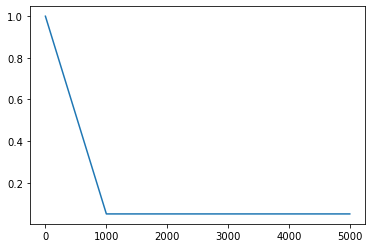

In [12]:
# So what's an easy way to check?
plt.plot([get_epsilon(it) for it in range(5000)])

Now write a function of *EpsilonGreedyPolicy* class. This function takes a state and uses the Q-network to select an ($\epsilon$-greedy) action. It should return a random action with probability epsilon. Note, you do not need to backpropagate through the model computations, so use `with torch.no_grad():` (see above for example). Note that to convert a PyTorch tensor with only 1 element (0 dimensional) to a simple python scalar (int or float), you can use the '.item()' function.

In [13]:
%%execwritefile -a dqn_autograde.py

class EpsilonGreedyPolicy(object):
    """
    A simple epsilon greedy policy.
    """
    def __init__(self, Q, epsilon):
        self.Q = Q.float()
        self.epsilon = epsilon
    
    def sample_action(self, obs):
        """
        This method takes a state as input and returns an action sampled from this policy.  

        Args:
            obs: current state

        Returns:
            An action (int).
        """
        # YOUR CODE HERE
        assert self.epsilon <= 1.0, 'epsilon>1 is not a valid probability!'
        policy_choice = np.random.choice(('greedy','non-greedy'), p=[1.0-self.epsilon, self.epsilon])
        
        if policy_choice == 'greedy':
            with torch.no_grad():
#                 print("before logits: ",torch.tensor(obs).float() )
                
                logits = self.Q(torch.tensor(obs).float())
#                 print("LOGITS: ",logits )
                action = torch.argmax(logits).item()
        elif policy_choice == 'non-greedy':
            action = random.choice([0,1])
        else:
            raise NotImplementedError
            
        return action
        
    def set_epsilon(self, epsilon):
        self.epsilon = epsilon

Appending to dqn_autograde.py


In [14]:
s = env.reset()
epg = EpsilonGreedyPolicy(Q_net, 0.05)
a = epg.sample_action(s)
assert not torch.is_tensor(a)
print (a)

2


### 2.4 Training function

Now we will implement the function 'train' that samples a batch from the memory and performs a gradient step using some convenient PyTorch functionality. However, you still need to compute the Q-values for the (state, action) pairs in the experience, as well as their target (e.g. the value they should move towards). What is the target for a Q-learning update? What should be the target if `next_state` is terminal (e.g. `done`)?

For computing the Q-values for the actions, note that the model returns all action values where you are only interested in a single action value. Because of the batch dimension, you can't use simple indexing, but you may want to have a look at [torch.gather](https://pytorch.org/docs/stable/torch.html?highlight=gather#torch.gather) or use [advanced indexing](https://docs.scipy.org/doc/numpy-1.13.0/reference/arrays.indexing.html) (numpy tutorial but works mostly the same in PyTorch). Note, you should NOT modify the function train. You can view the size of a tensor `x` with `x.size()` (similar to `x.shape` in numpy).

In [15]:
%%execwritefile -a dqn_autograde.py

def compute_q_vals(Q, states, actions):
    """
    This method returns Q values for given state action pairs.
    
    Args:
        Q: Q-net
        states: a tensor of states. Shape: batch_size x obs_dim
        actions: a tensor of actions. Shape: Shape: batch_size x 1

    Returns:
        A torch tensor filled with Q values. Shape: batch_size x 1.
    """
    # YOUR CODE HERE
#     print("STATES shape IS: ", states.shape)
    qvals = Q(states)
    q_sa = qvals.gather(1, actions)
    return q_sa
    
    
def compute_targets(Q, rewards, next_states, dones, discount_factor):
    """
    This method returns targets (values towards which Q-values should move).
    
    Args:
        Q: Q-net
        rewards: a tensor of actions. Shape: Shape: batch_size x 1
        next_states: a tensor of states. Shape: batch_size x obs_dim
        dones: a tensor of boolean done flags (indicates if next_state is terminal) Shape: batch_size x 1
        discount_factor: discount
    Returns:
        A torch tensor filled with target values. Shape: batch_size x 1.
    """
    # YOUR CODE HERE
    if dones.dtype != torch.uint8:
        dones = torch.tensor(dones, dtype=torch.uint8)
    q_sp = Q(next_states)
    maxq, _ = q_sp.max(dim=1, keepdim=True)
    targets = rewards + discount_factor * maxq * (1 - dones)
    return targets


def train(Q, memory, optimizer, batch_size, discount_factor, semi):
    # DO NOT MODIFY THIS FUNCTION
    
    # don't learn without some decent experience
    if len(memory) < batch_size:
        return None

    # random transition batch is taken from experience replay memory
    transitions = memory.sample(batch_size)
    
    # transition is a list of 4-tuples, instead we want 4 vectors (as torch.Tensor's)
    state, action, reward, next_state, done = zip(*transitions)
    
    # convert to PyTorch and define types
    state = torch.tensor(state, dtype=torch.float)
#     print("state is : ", state)
    action = torch.tensor(action, dtype=torch.int64)[:, None]  # Need 64 bit to use them as index
    next_state = torch.tensor(next_state, dtype=torch.float)
    reward = torch.tensor(reward, dtype=torch.float)[:, None]
    done = torch.tensor(done, dtype=torch.uint8)[:, None]  # Boolean

    # compute the q value
    q_val = compute_q_vals(Q, state, action)
    if semi==True:
        with torch.no_grad():  # Don't compute gradient info for the target (semi-gradient)
            target = compute_targets(Q, reward, next_state, done, discount_factor)
    else:
        target = compute_targets(Q, reward, next_state, done, discount_factor)
    
    # loss is measured from error between current and newly expected Q values
    loss = F.smooth_l1_loss(q_val, target)

    # backpropagation of loss to Neural Network (PyTorch magic)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.item()  # Returns a Python scalar, and releases history (similar to .detach())

Appending to dqn_autograde.py


In [16]:
# You may want to test your functions individually, but after you do so lets see if the method train works.
batch_size = 64
discount_factor = 0.8
learn_rate = 1e-3
# Simple gradient descent may take long, so we will use Adam
optimizer = optim.Adam(Q_net.parameters(), learn_rate)

# We need a larger memory, fill with dummy data
transition = memory.sample(1)[0]
memory = ReplayMemory(10 * batch_size)
for i in range(batch_size):
    memory.push(transition)

# Now let's see if it works
loss = train(Q_net, memory, optimizer, batch_size, discount_factor, False)

print (loss)

0.2648017108440399


### 2.5 Put it all together

Now that you have implemented the training step, you should be able to put everything together. Implement the function `run_episodes` that runs a number of episodes of DQN training. It should return the durations (e.g. number of steps) of each episode. Note: we pass the train function as an argument such that we can swap it for a different training step later.

In [17]:
%%execwritefile -a dqn_autograde.py

def run_episodes(train, Q, policy, memory, env, num_episodes, batch_size, discount_factor, learn_rate, semi):
    
    optimizer = optim.Adam(Q.parameters(), learn_rate)
    
    global_steps = 0  # Count the steps (do not reset at episode start, to compute epsilon)
    episode_durations = []  #
    for i in range(num_episodes):
        state = env.reset()
        
        steps = 0
        while True:
            # YOUR CODE HERE
            
            # get epsilon update
            epsilon = get_epsilon(global_steps)
            # update epsilon
            policy.set_epsilon(epsilon)
            # increment steps
            global_steps += 1
            steps += 1
            
            # sample action and store in memory
            action = policy.sample_action(state)
            s_next, reward, done, _ = env.step(action)
            memory.push((state, action, reward, s_next, done))
            loss = train(Q, memory, optimizer, batch_size, discount_factor, semi)
            state = s_next
            
#             if loss != None:
#                 print(loss)
            
            if done:
                if i % 10 == 0:
                    print("{2} Episode {0} finished after {1} steps"
                          .format(i, steps, '\033[92m' if steps >= 195 else '\033[99m'))
                episode_durations.append(steps)
                #plot_durations()
                break
    return episode_durations

Appending to dqn_autograde.py


In [23]:
# # Let's run it!
# num_episodes = 50
# batch_size = 64
# discount_factor = 0.8
# learn_rate = 1e-3
# memory = ReplayMemory(10000)
# num_hidden = 128
# seed = 42  # This is not randomly chosen

# # We will seed the algorithm (before initializing QNetwork!) for reproducibility
# random.seed(seed)
# torch.manual_seed(seed)
# env.seed(seed)

# semi_grad = False

# Q_net = QNetwork(num_hidden)
# policy = EpsilonGreedyPolicy(Q_net, 0.05)
# start = time.time()
# episode_durations = run_episodes(train, Q_net, policy, memory, env, num_episodes, batch_size, discount_factor, learn_rate, semi_grad)
# end = time.time()
# a = np.trasnpose(np.asarray(episode_durations))
# np.savetxt("foo.csv", a, delimiter=",")
# print("it took ", end - start, " seconds to run the program")

 Episode 0 finished after 500 steps
 Episode 10 finished after 500 steps
 Episode 20 finished after 209 steps
 Episode 30 finished after 264 steps
 Episode 40 finished after 336 steps
it took  33.08741617202759  seconds to run the program


In [47]:
seeds = []
runs = 10
num_episodes = 1000
results = np.zeros([runs,num_episodes])
for i in range(runs):
    
    batch_size = 64
    discount_factor = 0.8
    learn_rate = 1e-3
    memory = ReplayMemory(10000)
    num_hidden = 128
    
    seed = random.randint(1, 1000)  # This is not randomly chosen
    seeds.append(seed)

    # We will seed the algorithm (before initializing QNetwork!) for reproducibility
    random.seed(seed)
    torch.manual_seed(seed)
    env.seed(seed)

    semi_grad = False

    Q_net = QNetwork(num_hidden)
    policy = EpsilonGreedyPolicy(Q_net, 0.05)
    start = time.time()
    episode_durations = run_episodes(train, Q_net, policy, memory, env, num_episodes, batch_size, discount_factor, learn_rate, semi_grad)
    end = time.time()
    a = np.asarray(episode_durations)
    results[i] = a
    print("it took ", end - start, " seconds to run the program")

seedios = np.asarray(seeds)
np.savetxt("fullgrad_acrobot_1000_seeds.csv", a, delimiter=",")
pd.DataFrame(results).to_csv("fullgrad_acrobot_1000.csv")

 Episode 0 finished after 500 steps
 Episode 10 finished after 332 steps
 Episode 20 finished after 140 steps
 Episode 30 finished after 337 steps
 Episode 40 finished after 183 steps
 Episode 50 finished after 207 steps
 Episode 60 finished after 230 steps
 Episode 70 finished after 315 steps
 Episode 80 finished after 323 steps
 Episode 90 finished after 438 steps
 Episode 100 finished after 352 steps
 Episode 110 finished after 173 steps
 Episode 120 finished after 274 steps
 Episode 130 finished after 269 steps
 Episode 140 finished after 290 steps
 Episode 150 finished after 145 steps
 Episode 160 finished after 294 steps
 Episode 170 finished after 150 steps
 Episode 180 finished after 226 steps
 Episode 190 finished after 212 steps
 Episode 200 finished after 214 steps
 Episode 210 finished after 242 steps
 Episode 220 finished after 224 steps
 Episode 230 finished after 198 steps
 Episode 240 finished after 213 steps
 Episode 250 finished after 160 steps
 Episode 260 finished a

 Episode 900 finished after 233 steps
 Episode 910 finished after 247 steps
 Episode 920 finished after 286 steps
 Episode 930 finished after 156 steps
 Episode 940 finished after 255 steps
 Episode 950 finished after 261 steps
 Episode 960 finished after 340 steps
 Episode 970 finished after 274 steps
 Episode 980 finished after 176 steps
 Episode 990 finished after 214 steps
it took  593.4132721424103  seconds to run the program
 Episode 0 finished after 500 steps
 Episode 10 finished after 174 steps
 Episode 20 finished after 270 steps
 Episode 30 finished after 287 steps
 Episode 40 finished after 489 steps
 Episode 50 finished after 199 steps
 Episode 60 finished after 337 steps
 Episode 70 finished after 245 steps
 Episode 80 finished after 182 steps
 Episode 90 finished after 349 steps
 Episode 100 finished after 307 steps
 Episode 110 finished after 174 steps
 Episode 120 finished after 329 steps
 Episode 130 finished after 378 steps
 Episode 140 finished after 357 steps
 Episo

 Episode 790 finished after 103 steps
 Episode 800 finished after 207 steps
 Episode 810 finished after 159 steps
 Episode 820 finished after 434 steps
 Episode 830 finished after 302 steps
 Episode 840 finished after 100 steps
 Episode 850 finished after 142 steps
 Episode 860 finished after 311 steps
 Episode 870 finished after 500 steps
 Episode 880 finished after 347 steps
 Episode 890 finished after 258 steps
 Episode 900 finished after 144 steps
 Episode 910 finished after 289 steps
 Episode 920 finished after 211 steps
 Episode 930 finished after 326 steps
 Episode 940 finished after 240 steps
 Episode 950 finished after 340 steps
 Episode 960 finished after 374 steps
 Episode 970 finished after 301 steps
 Episode 980 finished after 407 steps
 Episode 990 finished after 173 steps
it took  526.6960489749908  seconds to run the program
 Episode 0 finished after 500 steps
 Episode 10 finished after 500 steps
 Episode 20 finished after 385 steps
 Episode 30 finished after 500 steps


 Episode 680 finished after 172 steps
 Episode 690 finished after 216 steps
 Episode 700 finished after 245 steps
 Episode 710 finished after 392 steps
 Episode 720 finished after 381 steps
 Episode 730 finished after 217 steps
 Episode 740 finished after 338 steps
 Episode 750 finished after 434 steps
 Episode 760 finished after 269 steps
 Episode 770 finished after 365 steps
 Episode 780 finished after 404 steps
 Episode 790 finished after 260 steps
 Episode 800 finished after 190 steps
 Episode 810 finished after 138 steps
 Episode 820 finished after 150 steps
 Episode 830 finished after 256 steps
 Episode 840 finished after 179 steps
 Episode 850 finished after 276 steps
 Episode 860 finished after 500 steps
 Episode 870 finished after 200 steps
 Episode 880 finished after 205 steps
 Episode 890 finished after 305 steps
 Episode 900 finished after 323 steps
 Episode 910 finished after 468 steps
 Episode 920 finished after 330 steps
 Episode 930 finished after 274 steps
 Episode 940

 Episode 570 finished after 182 steps
 Episode 580 finished after 173 steps
 Episode 590 finished after 384 steps
 Episode 600 finished after 466 steps
 Episode 610 finished after 492 steps
 Episode 620 finished after 500 steps
 Episode 630 finished after 247 steps
 Episode 640 finished after 174 steps
 Episode 650 finished after 213 steps
 Episode 660 finished after 333 steps
 Episode 670 finished after 200 steps
 Episode 680 finished after 165 steps
 Episode 690 finished after 148 steps
 Episode 700 finished after 149 steps
 Episode 710 finished after 380 steps
 Episode 720 finished after 353 steps
 Episode 730 finished after 228 steps
 Episode 740 finished after 344 steps
 Episode 750 finished after 500 steps
 Episode 760 finished after 292 steps
 Episode 770 finished after 240 steps
 Episode 780 finished after 336 steps
 Episode 790 finished after 327 steps
 Episode 800 finished after 500 steps
 Episode 810 finished after 261 steps
 Episode 820 finished after 379 steps
 Episode 830

 Episode 460 finished after 165 steps
 Episode 470 finished after 141 steps
 Episode 480 finished after 353 steps
 Episode 490 finished after 250 steps
 Episode 500 finished after 392 steps
 Episode 510 finished after 220 steps
 Episode 520 finished after 163 steps
 Episode 530 finished after 190 steps
 Episode 540 finished after 166 steps
 Episode 550 finished after 203 steps
 Episode 560 finished after 210 steps
 Episode 570 finished after 391 steps
 Episode 580 finished after 252 steps
 Episode 590 finished after 338 steps
 Episode 600 finished after 376 steps
 Episode 610 finished after 371 steps
 Episode 620 finished after 140 steps
 Episode 630 finished after 302 steps
 Episode 640 finished after 156 steps
 Episode 650 finished after 432 steps
 Episode 660 finished after 432 steps
 Episode 670 finished after 301 steps
 Episode 680 finished after 229 steps
 Episode 690 finished after 499 steps
 Episode 700 finished after 171 steps
 Episode 710 finished after 342 steps
 Episode 720

In [40]:
print(results)

[[500. 500. 149. 300. 220. 500. 179. 337. 336. 228. 167. 500. 500. 302.
  353. 500. 500. 297. 500. 298.]
 [500. 500. 176. 155. 462. 158. 184. 154. 179. 282. 165. 232. 414. 500.
  500. 400. 333. 380. 500. 185.]
 [500. 500. 283. 500. 407. 500. 500. 468. 500. 500. 410. 394. 206. 299.
  395. 352. 500. 345. 411. 160.]
 [500. 432. 500. 500. 500. 299. 278. 334. 278. 336. 320. 381. 254. 190.
  239. 257. 284. 279. 298. 418.]
 [500. 500. 500. 500. 500. 418. 500. 500. 406. 359. 317. 270. 160. 254.
  386. 500. 500. 500. 500. 197.]
 [500. 500. 274. 196. 433. 194. 127. 258. 279. 391. 500. 378. 410. 346.
  312. 417. 240. 314. 213. 294.]
 [500. 500. 500. 500. 500. 500. 500. 500. 468. 500. 500. 500. 500. 500.
  500. 500. 320. 274. 500. 258.]
 [500. 500. 500. 500. 500. 242. 500. 154. 227. 259. 329. 240. 271. 232.
  446. 500. 452. 500. 500. 500.]
 [500. 500. 157. 276. 500. 500. 500. 222. 190. 239. 218. 161. 305. 156.
  500. 185. 138. 357. 205. 291.]
 [500. 423. 319. 259. 500. 500. 500. 257. 335. 500. 363

Text(0.5, 1.0, 'Episode durations per episode')

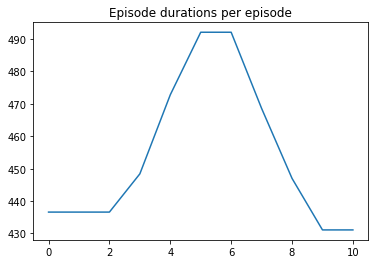

In [35]:
# And see the results
def smooth(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

plt.plot(smooth(episode_durations, 10))
plt.title('Episode durations per episode')

If you want to test/submit your solution **restart the kernel, run all cells and submit the dqn_autograde.py file into codegrade.**

In [20]:
# Let's run it!
num_episodes = 1000
batch_size = 64
discount_factor = 0.8
learn_rate = 1e-3
memory = ReplayMemory(10000)
num_hidden = 128
seed = 42  # This is not randomly chosen

# We will seed the algorithm (before initializing QNetwork!) for reproducibility
random.seed(seed)
torch.manual_seed(seed)
env.seed(seed)

semi_grad = True

Q_net = QNetwork(num_hidden)
policy = EpsilonGreedyPolicy(Q_net, 0.05)
start = time.time()
episode_durations = run_episodes(train, Q_net, policy, memory, env, num_episodes, batch_size, discount_factor, learn_rate, semi_grad)
end = time.time()
print("it took ", end - start, " seconds to run the program")

 Episode 0 finished after 500 steps
 Episode 10 finished after 500 steps
 Episode 20 finished after 500 steps
 Episode 30 finished after 452 steps
 Episode 40 finished after 337 steps
 Episode 50 finished after 248 steps


KeyboardInterrupt: 

In [ ]:
plt.plot(smooth(episode_durations, 10))
plt.title('Episode durations per episode')